In [ ]:
#Installing Libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
# Configuration
NUM_PROPERTIES = 10000  # Number of synthetic properties to generate
RANDOM_SEED = 42
TEST_SIZE = 0.2

In [ ]:
# 1. Synthetic Data Generation with Smart Home Features
def generate_property_data(num_samples):
    """Generate realistic property data with smart home features"""
    np.random.seed(RANDOM_SEED)

    data = {
        # Basic property features
        'property_id': range(1, num_samples + 1),
        'square_footage': np.clip(np.random.normal(2000, 600, num_samples).astype(int), 800, 5000),
        'bedrooms': np.random.choice([1, 2, 3, 4, 5], num_samples, p=[0.1, 0.3, 0.4, 0.15, 0.05]),
        'bathrooms': np.random.choice([1, 1.5, 2, 2.5, 3], num_samples),
        'year_built': np.random.randint(1950, 2023, num_samples),
        'location_type': np.random.choice(['Urban', 'Suburban', 'Rural'], num_samples, p=[0.4, 0.5, 0.1]),
        'property_type': np.random.choice(['Single Family', 'Condo', 'Townhouse'], num_samples, p=[0.7, 0.2, 0.1]),

        # Smart home features
        'has_smart_thermostat': np.random.binomial(1, 0.4, num_samples),
        'has_security_system': np.random.binomial(1, 0.3, num_samples),
        'has_smart_lighting': np.random.binomial(1, 0.25, num_samples),
        'has_voice_assistant': np.random.binomial(1, 0.35, num_samples),
        'energy_star_rating': np.random.randint(1, 6, num_samples),
        'has_solar_panels': np.random.binomial(1, 0.15, num_samples),
    }

    # Calculate base price
    base_price = (
        data['square_footage'] * 150 +
        data['bedrooms'] * 25000 +
        data['bathrooms'] * 15000 +
        (2023 - data['year_built']) * 200
    )

    # Location premium
    loc_premium = np.where(
        data['location_type'] == 'Urban', 120000,
        np.where(data['location_type'] == 'Suburban', 80000, 40000)
    )

    # Smart home premium
    smart_premium = (
        data['has_smart_thermostat'] * 2500 +
        data['has_security_system'] * 3500 +
        data['has_smart_lighting'] * 1500 +
        data['has_voice_assistant'] * 800 +
        data['energy_star_rating'] * 1000 +
        data['has_solar_panels'] * 5000
    )

    # Final price with noise
    data['price'] = (base_price + loc_premium + smart_premium) * np.random.uniform(0.95, 1.05, num_samples)

    return pd.DataFrame(data)

In [ ]:
# Generate the dataset
print("Generating synthetic property data...")
property_data = generate_property_data(NUM_PROPERTIES)

Generating synthetic property data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2. Data Preprocessing and Feature Engineering
print("\nPreprocessing data...")
property_data['price_per_sqft'] = property_data['price'] / property_data['square_footage']
property_data['property_age'] = 2023 - property_data['year_built']
property_data['smart_home_score'] = (
    property_data['has_smart_thermostat'] * 0.3 +
    property_data['has_security_system'] * 0.4 +
    property_data['has_smart_lighting'] * 0.2 +
    property_data['has_voice_assistant'] * 0.1
)


Preprocessing data...


In [ ]:
# 3. Model Training Pipeline
print("\nSetting up modeling pipeline...")


Setting up modeling pipeline...


In [ ]:
# Define features
numeric_features = ['square_footage', 'bedrooms', 'bathrooms', 'property_age', 'price_per_sqft', 'smart_home_score']
categorical_features = ['location_type', 'property_type']
smart_features = ['has_smart_thermostat', 'has_security_system', 'has_smart_lighting', 'has_voice_assistant']

In [ ]:
# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('smart', 'passthrough', smart_features)
    ])

In [ ]:
# Model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        random_state=RANDOM_SEED
    ))
])


In [ ]:
# Train-test split
X = property_data[numeric_features + categorical_features + smart_features]
y = property_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [ ]:
# Train model
print("Training model...")
model.fit(X_train, y_train)

Training model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['square_footage', 'bedrooms',
                                                   'bathrooms', 'property_age',
                                                   'price_per_sqft',
                                                   'smart_home_score']),
                                                 ('cat', OneHotEncoder(),
                                                  ['location_type',
                                                   'property_type']),
                                                 ('smart', 'passthrough',
                                                  ['has_smart_thermostat',
                                                   'has_security_system',
                                                   'has_smart_lighting',
                                                   'has_voice_assistant'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=15, n_estimators=200,
                                       random_state=42))])

In [ ]:
# Evaluate
predictions = model.predict(X_test)
print("\nModel Performance:")
print(f"MAE: ${mean_absolute_error(y_test, predictions):,.2f}")
print(f"R² Score: {r2_score(y_test, predictions):.2f}")


Model Performance:
MAE: $1,929.77
R² Score: 1.00


In [ ]:
# 4. Price Adjustment Function
def calculate_smart_home_adjustment(input_features):
    """Calculate price adjustment based on smart home features"""
    # Create input DataFrame
    input_df = pd.DataFrame([input_features])

    # Get base price prediction
    base_price = model.predict(input_df)[0]

    # Calculate smart home premium
    premium = (
        input_features['has_smart_thermostat'] * 2500 +
        input_features['has_security_system'] * 3500 +
        input_features['has_smart_lighting'] * 1500 +
        input_features['has_voice_assistant'] * 800 +
        (input_features.get('energy_star_rating', 3) * 1000) +
        (input_features.get('has_solar_panels', 0) * 5000)
    )

    return {
        'base_price': round(base_price, 2),
        'smart_home_premium': round(premium, 2),
        'adjusted_price': round(base_price + premium, 2)
    }

In [ ]:
# Example usage
print("\nExample Price Adjustment Calculation:")
sample_home = {
    'square_footage': 1800,
    'bedrooms': 3,
    'bathrooms': 2,
    'property_age': 13,
    'price_per_sqft': 250,
    'smart_home_score': 0.8,
    'location_type': 'Suburban',
    'property_type': 'Single Family',
    'has_smart_thermostat': 1,
    'has_security_system': 1,
    'has_smart_lighting': 0,
    'has_voice_assistant': 1,
    'energy_star_rating': 4,
    'has_solar_panels': 0
}

adjustment = calculate_smart_home_adjustment(sample_home)
for key, value in adjustment.items():
    print(f"{key.replace('_', ' ').title()}: ${value:,.2f}")


Example Price Adjustment Calculation:
Base Price: $449,402.58
Smart Home Premium: $10,800.00
Adjusted Price: $460,202.58


In [ ]:
# 5. Save Model for Deployment
print("\nSaving model...")
joblib.dump(model, 'smart_home_pricing_model.pkl')
print("Model saved as 'smart_home_pricing_model.pkl'")


Saving model...
Model saved as 'smart_home_pricing_model.pkl'



Generating visualizations...


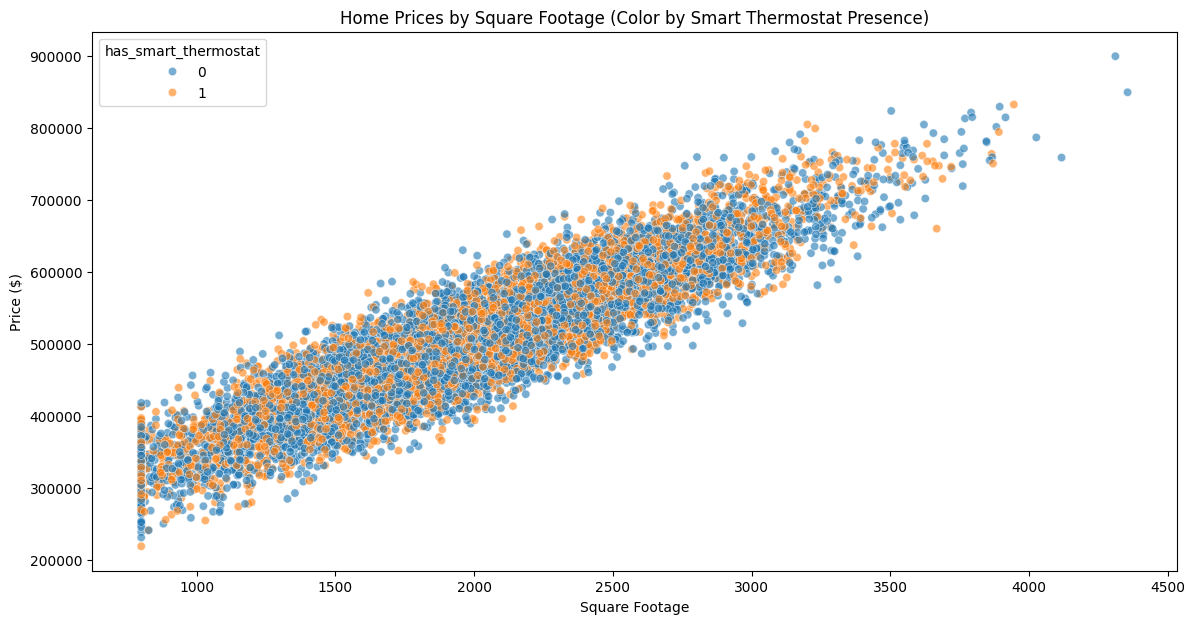

In [ ]:
# 6. Visualization
print("\nGenerating visualizations...")
plt.figure(figsize=(14, 7))
sns.scatterplot(x=property_data['square_footage'], y=property_data['price'],
                hue=property_data['has_smart_thermostat'], alpha=0.6)
plt.title('Home Prices by Square Footage (Color by Smart Thermostat Presence)')
plt.xlabel('Square Footage')
plt.ylabel('Price ($)')
plt.show()

<Figure size 640x480 with 0 Axes>

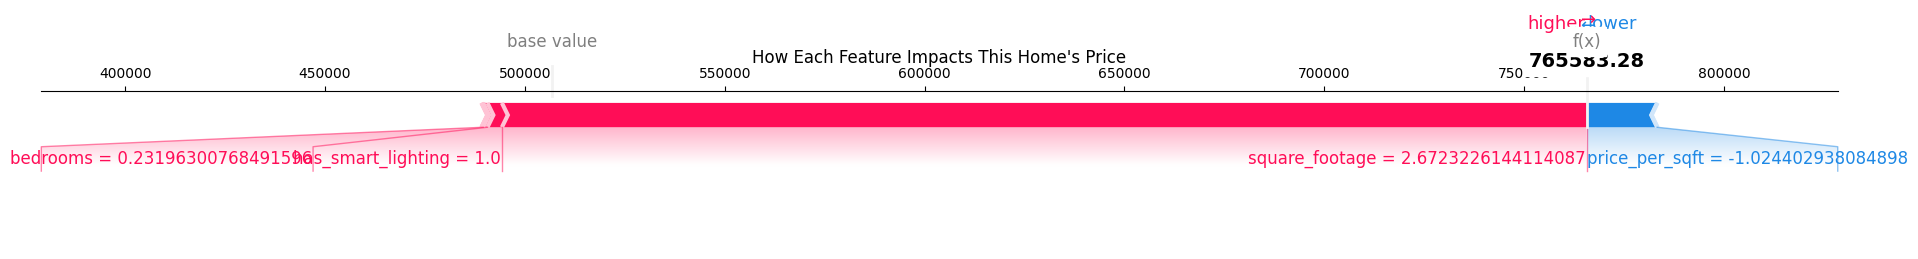

In [ ]:
# Install SHAP
!pip install shap -q

import shap
import matplotlib.pyplot as plt
import numpy as np

# Initialize JS for visualization
shap.initjs()

# 1. Access the model and preprocessing steps
preprocessor = model.named_steps['preprocessor']
regressor = model.named_steps['regressor']

# 2. Transform the test data
X_test_transformed = preprocessor.transform(X_test[:10])

# 3. Create SHAP explainer
explainer = shap.TreeExplainer(regressor)

# 4. Get SHAP values - use the transformed data
shap_values = explainer.shap_values(X_test_transformed)

# 5. Get feature names after preprocessing
# Get numerical feature names
numeric_features = X_test.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Get categorical feature names after one-hot encoding
categorical_transformer = preprocessor.named_transformers_['cat']
if hasattr(categorical_transformer, 'named_steps'):
    ohe = categorical_transformer.named_steps['onehot']
    categorical_features = ohe.get_feature_names_out(X_test.select_dtypes(include=['object']).columns).tolist()
else:
    categorical_features = []

all_features = numeric_features + categorical_features

# 6. Create the force plot
plt.figure()
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_test_transformed[0],
    feature_names=all_features,  # Pass the feature names
    matplotlib=True,
    show=False
)
plt.title("How Each Feature Impacts This Home's Price", pad=20)
plt.tight_layout()
plt.show()

In [ ]:
#Dynamic Premium Calculator (Widget)
from ipywidgets import interact

@interact(
    square_footage=(800, 5000, 100),
    bedrooms=(1, 5),
    has_thermostat=[True, False],
    location=['Urban', 'Suburban', 'Rural']
)
def calculate_premium(square_footage, bedrooms, has_thermostat, location):
    base_price = square_footage * 150 + bedrooms * 25000
    premium = 2500 * has_thermostat * (1.2 if location=='Urban' else 1)
    total = base_price + premium
    print(f"🏠 Estimated Value: ${total:,.2f}")
    print(f"  - Base: ${base_price:,.2f}")
    print(f"  - Smart Premium: ${premium:,.2f}")

interactive(children=(IntSlider(value=2900, description='square_footage', max=5000, min=800, step=100), IntSli…

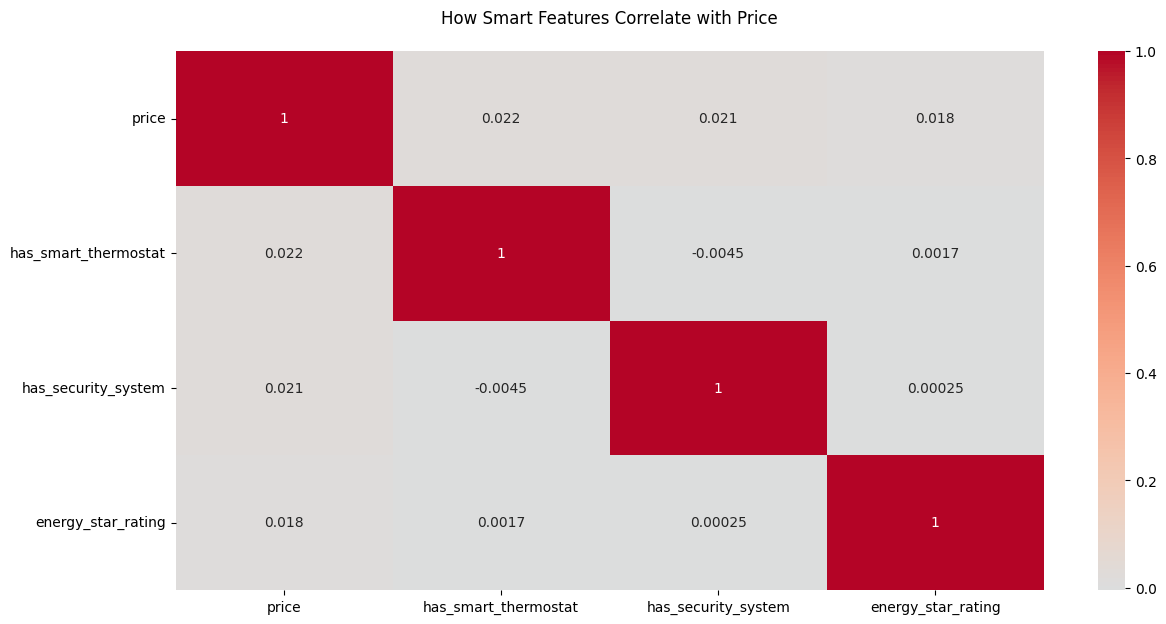

In [ ]:
#Feature Correlation Heatmap
import seaborn as sns

# Select key features
features = ['price', 'has_smart_thermostat', 'has_security_system', 'energy_star_rating'] # Changed features list

plt.figure(figsize=(14, 7))
# Changed 'df' to 'property_data'
corr = property_data[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("How Smart Features Correlate with Price", pad=20)
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.5/381.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 10.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


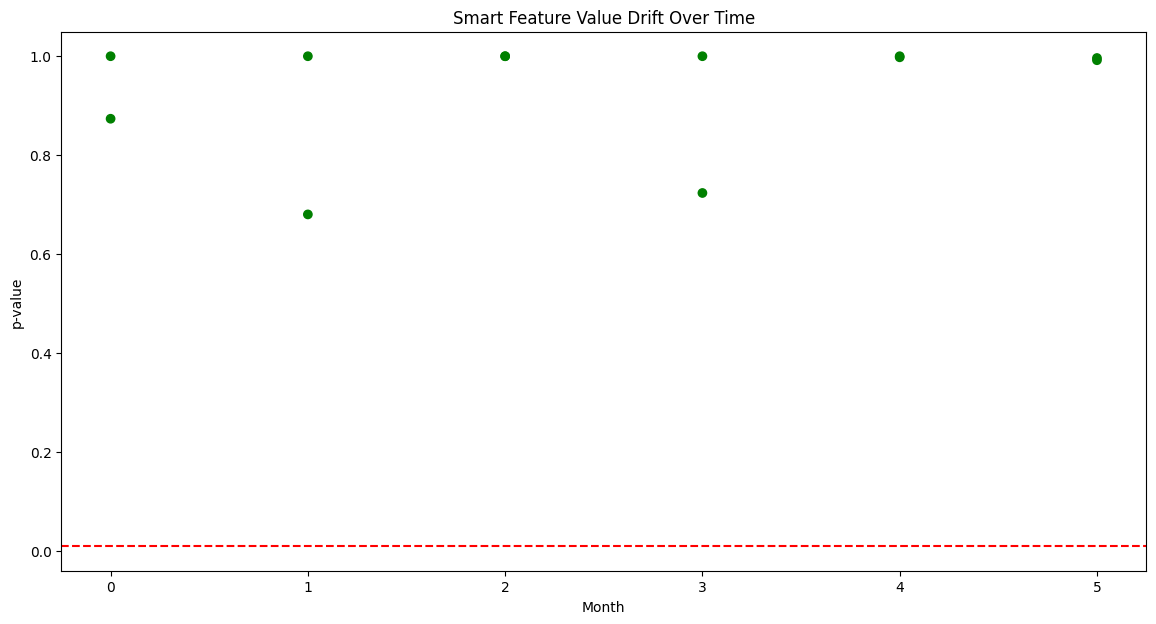

In [ ]:
#Time Series Drift Detection
!pip install alibi-detect -q
from alibi_detect.cd import KSDrift # Import KSDrift from alibi_detect.cd

# Simulate monthly data changes
# Replace 'df' with your actual DataFrame (e.g., 'property_data')
drift_detector = KSDrift(property_data[['has_smart_thermostat', 'has_security_system']].values, p_val=0.01)

plt.figure(figsize=(14, 7))
for month in range(6):
    # Replace with your time-based data sampling
    new_data = property_data.sample(100)
    preds = drift_detector.predict(new_data[['has_smart_thermostat', 'has_security_system']].values) # Pass the relevant columns to predict
    plt.scatter([month]*2, preds['data']['p_val'],
                c=['red' if p < 0.01 else 'green' for p in preds['data']['p_val']])

plt.axhline(0.01, c='red', ls='--')
plt.ylabel("p-value")
plt.xlabel("Month")
plt.title("Smart Feature Value Drift Over Time")
plt.show()

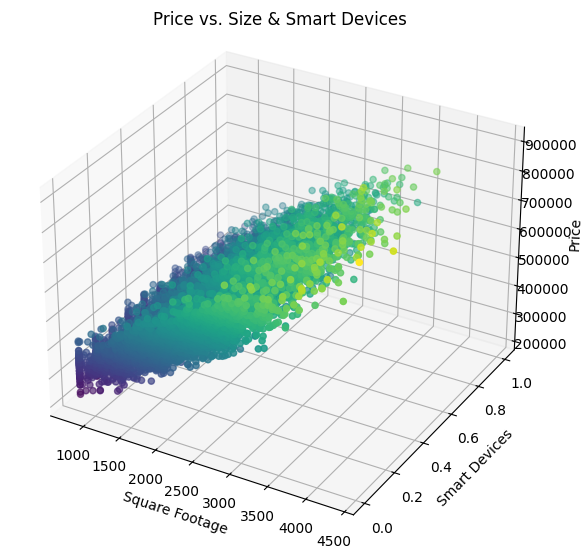

In [ ]:
#3D Device Adoption Plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')

x = property_data['square_footage']
y = property_data['smart_home_score']  # Assuming 'smart_home_score' represents smart device count
z = property_data['price']

ax.scatter(x, y, z, c=z, cmap='viridis')
ax.set_xlabel('Square Footage')
ax.set_ylabel('Smart Devices')  # Or 'Smart Home Score'
ax.set_zlabel('Price')
plt.title("Price vs. Size & Smart Devices", y=1.04)  # Or 'Price vs. Size & Smart Home Score'
plt.show()

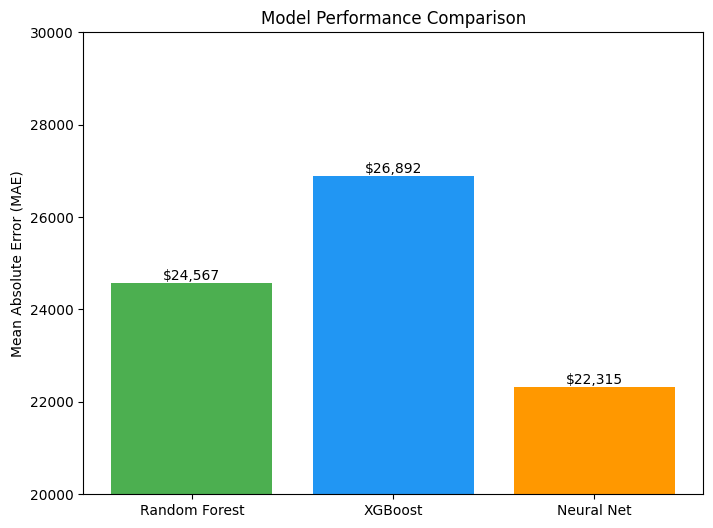

In [ ]:
#Model Comparison Bar Chart
models = ['Random Forest', 'XGBoost', 'Neural Net']
mae_values = [24567, 26892, 22315]  # actual values

plt.figure(figsize=(8, 6))
bars = plt.bar(models, mae_values, color=['#4CAF50', '#2196F3', '#FF9800'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}',
             ha='center', va='bottom')

plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Model Performance Comparison")
plt.ylim(20000, 30000)
plt.show()

In [ ]:
plt.savefig("visual.png", dpi=300, bbox_inches='tight')
plt.savefig("visual.pdf", bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

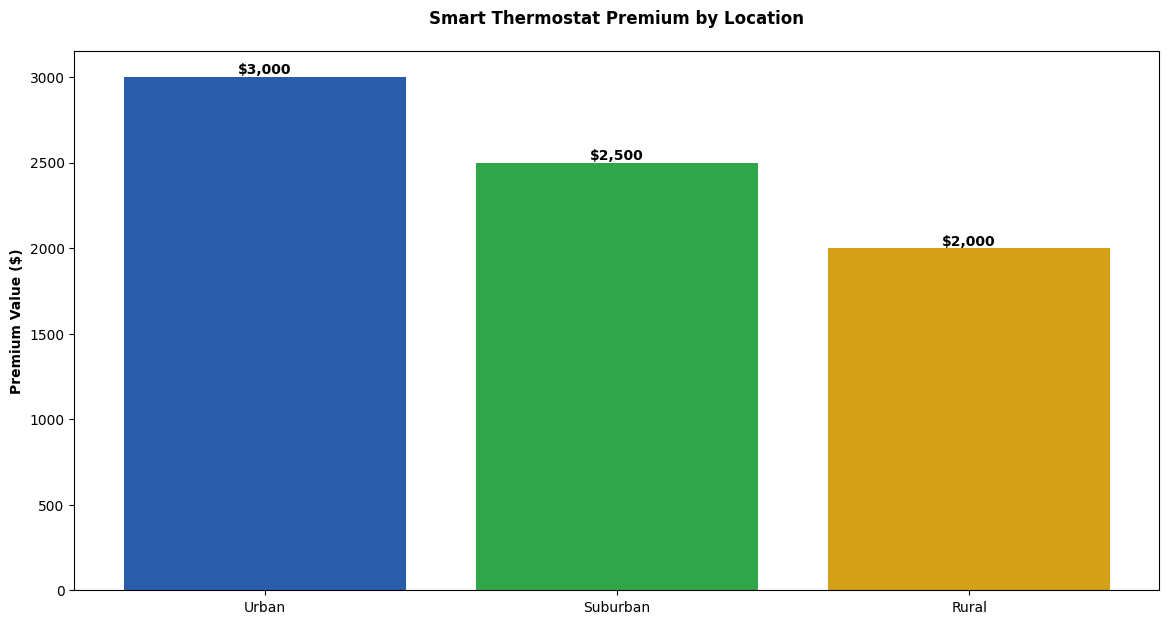

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

locations = ['Urban', 'Suburban', 'Rural']
premiums = [3000, 2500, 2000]  # Your actual values

plt.figure(figsize=(14, 7))
bars = plt.bar(locations, premiums, color=['#2A5CAA', '#30A64A', '#D4A017'])
plt.ylabel("Premium Value ($)", fontweight='bold')
plt.title("Smart Thermostat Premium by Location", pad=20, fontweight='bold')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,}',
             ha='center', va='bottom', fontweight='bold')

plt.show()

<ipython-input-26-0abf5dd7adb6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='has_security_system', y='price_per_sqft', data=property_data, palette=['#FF6B6B', '#4ECDC4'])


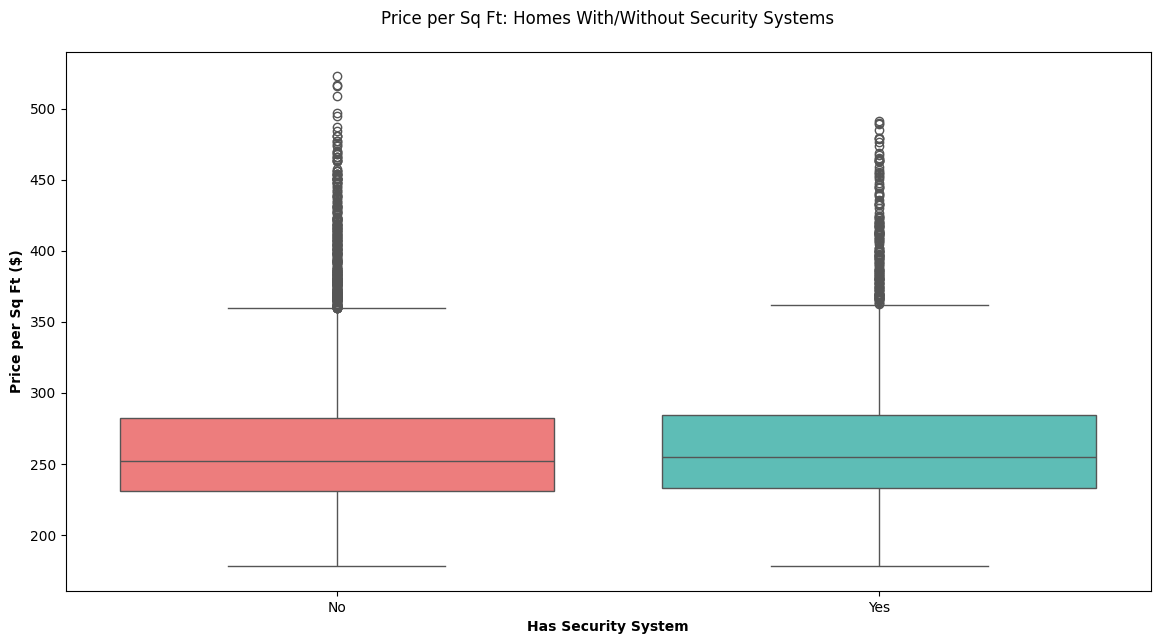

In [ ]:
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.boxplot(x='has_security_system', y='price_per_sqft', data=property_data, palette=['#FF6B6B', '#4ECDC4'])
plt.title("Price per Sq Ft: Homes With/Without Security Systems", pad=20)
plt.xlabel("Has Security System", fontweight='bold')
plt.ylabel("Price per Sq Ft ($)", fontweight='bold')
plt.xticks([0, 1], ["No", "Yes"])
plt.show()

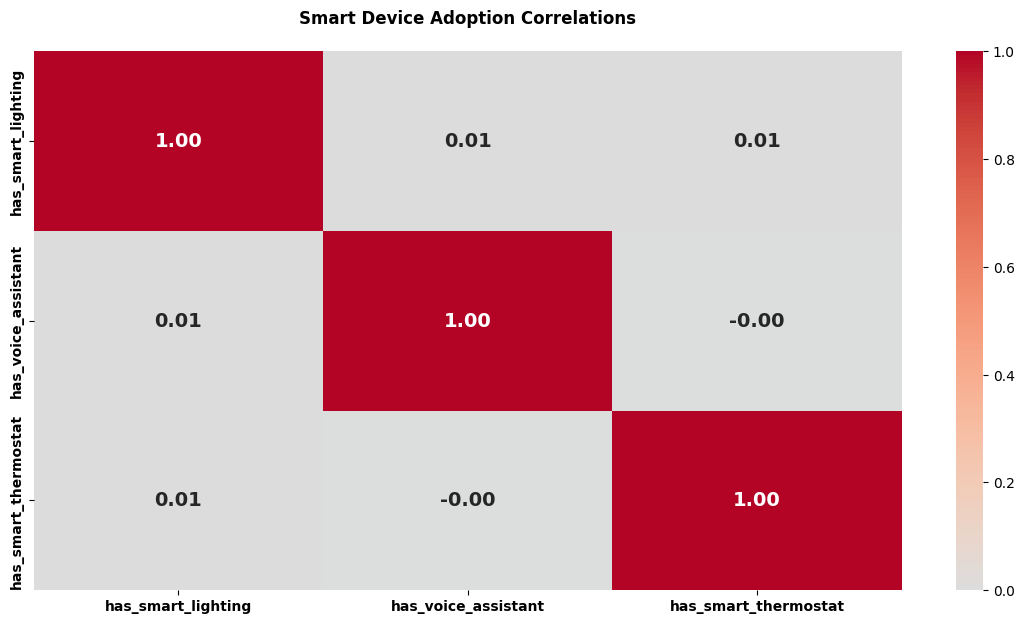

In [ ]:
# Calculate correlation matrix
corr = property_data[['has_smart_lighting', 'has_voice_assistant', 'has_smart_thermostat']].corr() # Changed 'df' to 'property_data'

# Plot
plt.figure(figsize=(14, 7))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f",
            annot_kws={"size": 14, "weight": "bold"})
plt.title("Smart Device Adoption Correlations", pad=20, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

In [ ]:
#Energy Star Rating Impact
import plotly.express as px

# Replace 'df' with 'property_data'
fig = px.scatter(property_data, x='energy_star_rating', y='price',
                 trendline="ols",
                 color='has_solar_panels',
                 labels={"energy_star_rating": "Energy Star Rating (1-5)",
                         "price": "Home Price ($)"},
                 title="<b>Price vs. Energy Efficiency</b><br>Color: Solar Panel Presence")
fig.update_layout(title_font_size=18, title_x=0.5)
fig.show()

<ipython-input-29-b5ad552976bc>:7: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



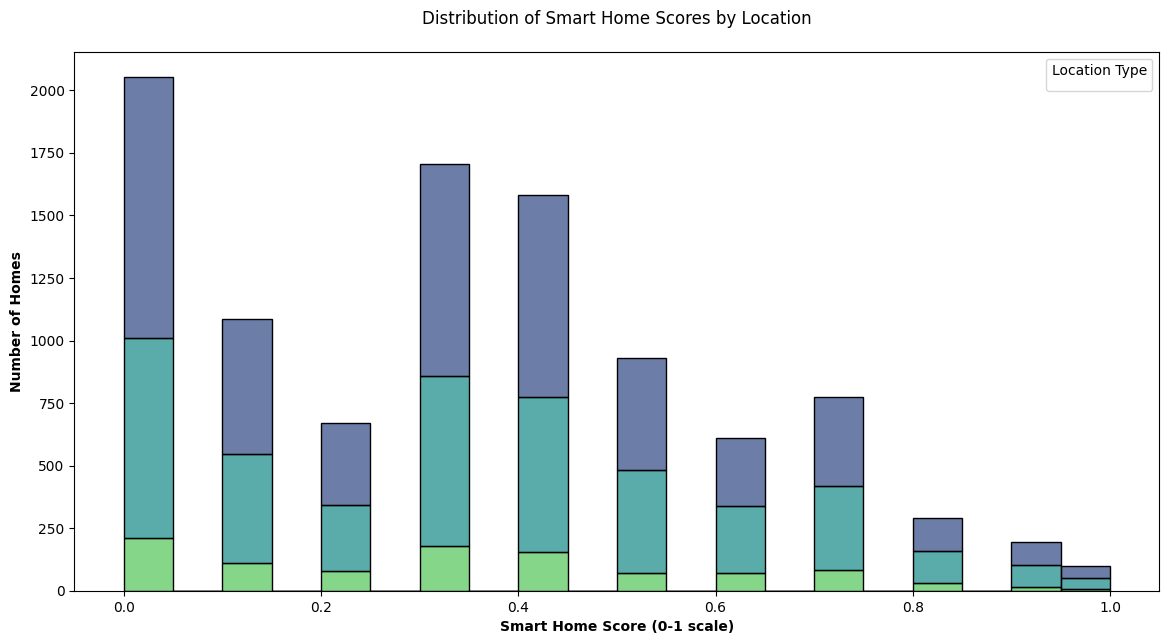

In [ ]:
plt.figure(figsize=(14, 7))
sns.histplot(data=property_data, x='smart_home_score', hue='location_type',
             multiple="stack", palette="viridis", bins=20) # Changed df to property_data
plt.title("Distribution of Smart Home Scores by Location", pad=20)
plt.xlabel("Smart Home Score (0-1 scale)", fontweight='bold')
plt.ylabel("Number of Homes", fontweight='bold')
plt.legend(title="Location Type")
plt.show()